In [13]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from typing import Optional
from matplotlib.axes import Axes

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 30

RESULT_PATH = Path("../output/result.csv")
METRICS_MAP = {
    "exec_time": "CPU time (s)",
    "exec_time_rate": "実行時間の比率",
    "user_util": "User utility",
    "mean_max_envy": "Mean max envy",
    "pct_item_util_better": "Items better off (%)",
    "pct_item_util_worse": "Items worse off (%)",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    "greedy": "MaxRele",
    "expo_fair": "ExpFair",
    "nsw": "NSW",
    "greedy_nsw": "NSW(Greedy)",
    "ot_nsw": "NSW(Algo1)",
    "pgd_nsw": "NSW (射影勾配法) ",
}
METHOD_TO_COLOR = {
    "MaxRele": "#E24A33",
    "ExpFair": "#FBC15E",
    "ExpFair(Mosek)": "#FBC15E",
    "ExpFair(SCS)": "#FBC15E",
    "NSW(Greedy)": "#777777",
    "NSW (既存) ": "#988ED5",
    "NSW(Mosek)": "#988ED5",
    "NSW(SCS)": "#988ED5",
    "NSW(Algo1)": "#348ABD",
    "NSW(Algo1+GPU)": "#348ABD",
    "NSW (射影勾配法) ": "#8EBA42",
}
METHOD_TO_LINESTYLE = {
    "MaxRele": "-",
    "ExpFair": "-",
    "ExpFair(Mosek)": "-",
    "閲覧公平 (SCS) ": "-",
    "NSW(Greedy)": "-",
    "NSW (既存) ": "-",
    "NSW(Mosek)": "-",
    "NSW (SCS) ": "-",
    "NSW(Algo1)": "--",
    "NSW(Algo1+GPU)": "-",
    "NSW (射影勾配法) ": "-",
}

In [14]:
def load_result(
    path: Path,
    exp_names: list[str],
    on: list[str] = ["seed"],
    ideal_method: str = "NSW(Mosek)",
    ignore_methods: list[str] = ["pg_ot"],
    ignore_solver: list[str] = ["SCS"],
    consider_solver: bool = True,
    consider_device: bool = False,
    dropna: bool = True,
) -> pd.DataFrame:
    result = pd.read_csv(path)

    # Filter by experiment name
    result = result.query(f"exp_name in {exp_names}")
    # # Filter by optimizer params method
    result = result.query(f"optimizer_name not in {ignore_methods}").reset_index(drop=True)
    # Filter by solver
    if consider_solver:
        result = result.query(f"optimizer_params_solver not in {ignore_solver}").reset_index(
            drop=True
        )
    # Filter by device
    if not consider_device:
        result = result.query("optimizer_params_device != 'cpu'").reset_index(drop=True)

    # Initialize metrics
    result["exec_time_rate"] = np.nan

    # rename method
    result["method"] = result["optimizer_name"].map(METHOD_MAP)
    if consider_solver:
        # solverがMOSEKだったらMosekに変更
        result["optimizer_params_solver"] = result["optimizer_params_solver"].replace(
            {"MOSEK": "Mosek"}
        )
        result["optimizer_params_solver"] = result["optimizer_params_solver"].apply(
            lambda x: f"({x})" if x == x else ""
        )
        result["method"] += result["optimizer_params_solver"]
    if consider_device:
        # optimizer_params_deviceがcudaだったらmethodはNSW(Algo1+GPU)に変更
        result["method"] = result["method"].mask(
            result["optimizer_params_device"].fillna("") == "cuda", "NSW(Algo1+GPU)"
        )

    #
    ideal = result.query("method == @ideal_method").reset_index(drop=True)
    ideal = ideal.drop_duplicates(subset=on)
    result = pd.merge(
        result[on + ["method"] + METRICS],
        ideal[on + METRICS],
        on=on,
        suffixes=("", "_nsw"),
        how="left",
    )

    # Calculate exec_time_rate
    result["exec_time_rate"] = result["exec_time"] / result["exec_time_nsw"]

    # drop na
    num_na: pd.DataFrame = result[METRICS].isna().sum(axis=0).to_frame()
    num_na.columns = ["number_of_nan"]
    display(num_na)
    if dropna:
        result = result.dropna(subset=METRICS)

    return result.reset_index(drop=True)

In [15]:
base_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    consider_device=False,
    dropna=False,
    ignore_methods=["pgd_nsw"],
)

,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


# ベースサイズの実験

In [16]:
def plot_metrics_bar(
    base_size_result: pd.DataFrame,
    metrics: list[str] = [
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
) -> None:
    n_metrics = len(metrics)
    fig, axes = plt.subplots(ncols=n_metrics, figsize=(10 * n_metrics, 11), tight_layout=True)
    axes = np.ravel(axes)

    unique_method = base_size_result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]
    pallete = [METHOD_TO_COLOR[method] for method in order]

    for i, metric in enumerate(metrics):
        ax = sns.barplot(
            base_size_result,
            x="method",
            y=metric,
            ax=axes[i],
            legend=True,
            order=order,
            palette=pallete,
            hue="method",
            hue_order=order,
            errorbar=None,
        )
        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis="both", labelsize=35)
        ax.set_xticks([])

        if metric in ["pct_item_util_better", "pct_item_util_worse"]:
            ax.set_ylim(0, 105)

        # 棒グラフの上に値を追加
        for j, p in enumerate(ax.patches):
            height = p.get_height()
            if (height == 0) & (p.get_x() == 0):  # monky patch
                continue
            ax.text(
                p.get_x() + p.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=35,
            )

        handles, legend = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(
        handles,
        legend,
        fontsize=50,
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(order),
        loc="upper center",
    )

## データの読み込み

In [17]:
# 人工データ
base_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    ignore_methods=["pgd_nsw"],
)
display(base_size_result.head(5))

# 実データ
base_size_real_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base_real"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    ignore_methods=["pgd_nsw"],
)

,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,generator_params_n_doc,generator_K,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1000.0,500,10,4,NSW(Algo1),3.245440,0.000637,2.157313,0.000091,97.4,0.0,5093.972370,NaN,2.158096,0.000038,97.0,0.0
1,1000.0,500,10,3,NSW(Algo1),2.741403,0.000603,2.184140,0.000104,97.4,0.0,4549.397303,NaN,2.184864,0.000041,97.4,0.0
2,1000.0,500,10,2,NSW(Algo1),2.237131,0.000556,2.142570,0.000087,96.8,0.2,4020.717532,NaN,2.143812,0.000037,97.0,0.2
3,1000.0,500,10,1,NSW(Algo1),1.713122,0.000494,2.144855,0.000094,97.8,0.0,3467.584497,NaN,2.145651,0.000039,97.8,0.0
4,1000.0,500,10,0,NSW(Algo1),1.219407,0.000419,2.153757,0.000090,97.0,0.0,2912.228539,NaN,2.155045,0.000040,97.2,0.0


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


### 人工データ

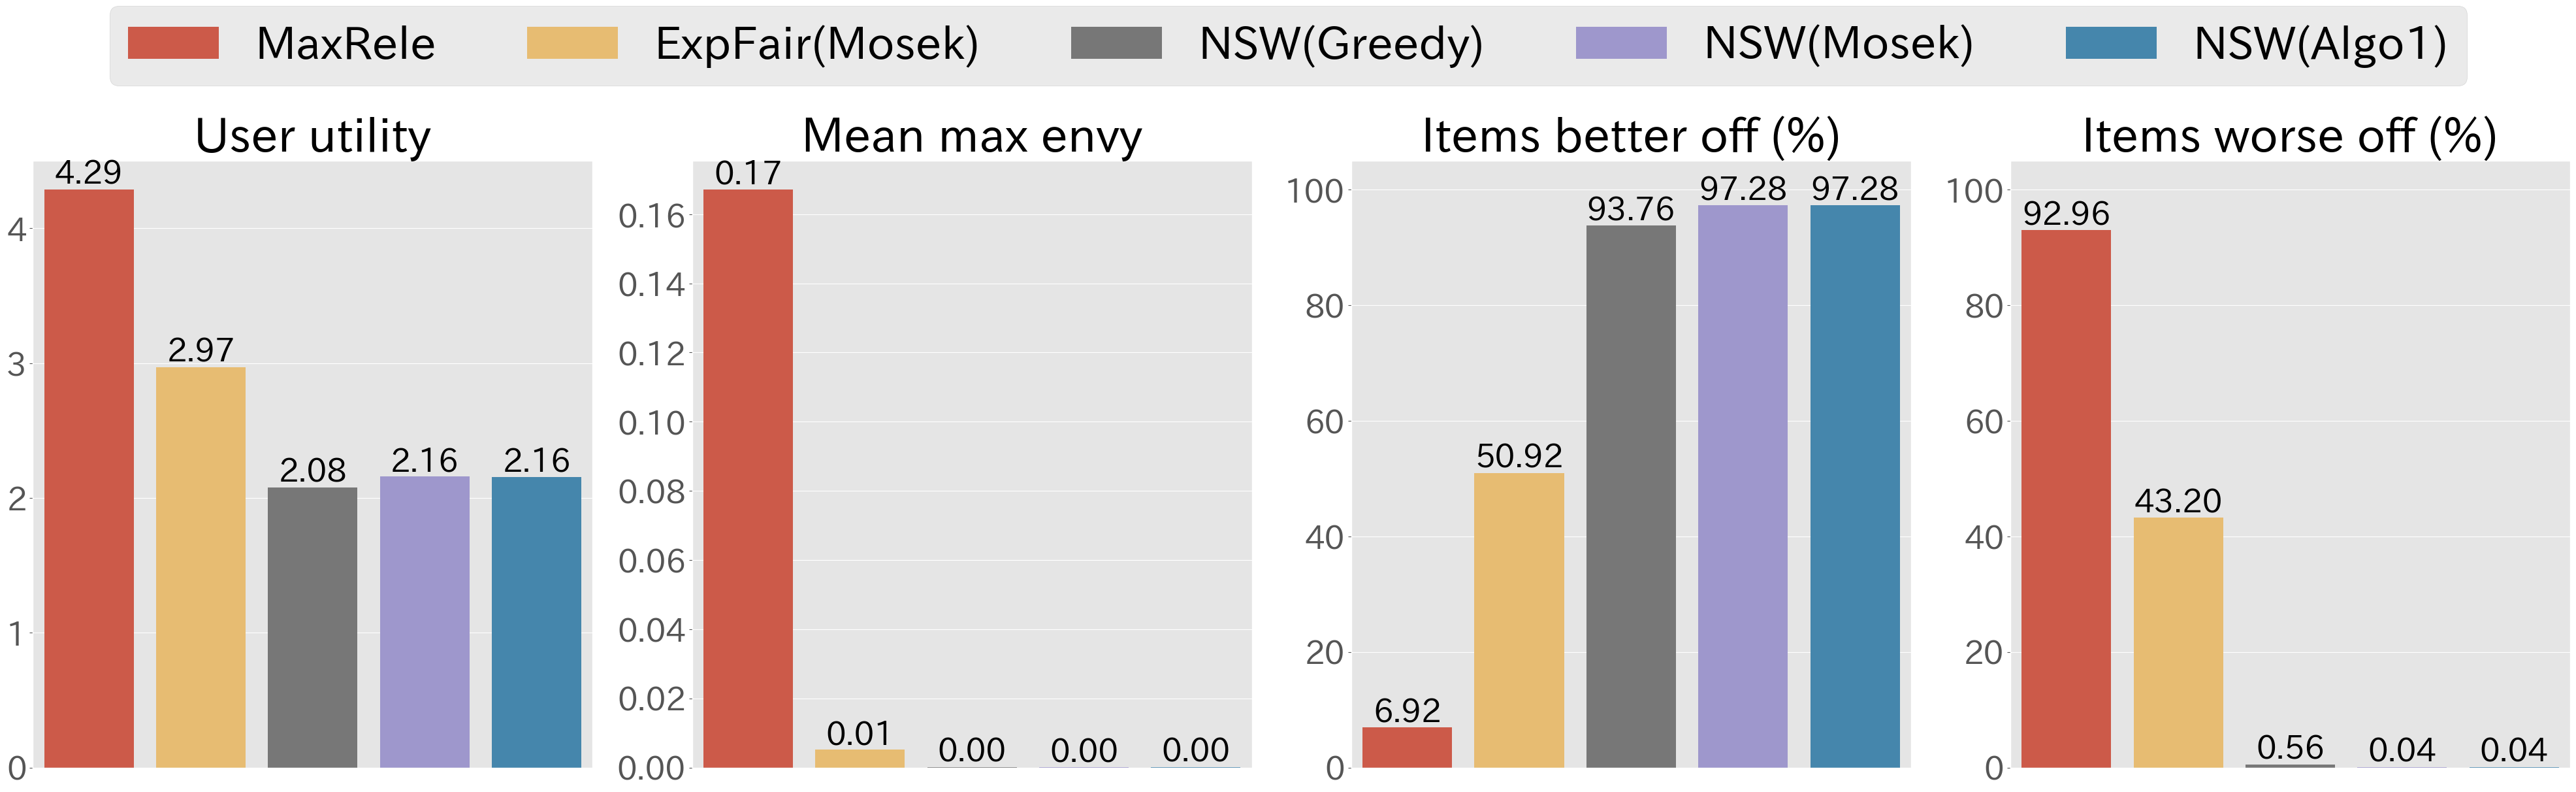

In [18]:
plot_metrics_bar(base_size_result)

### 実データ

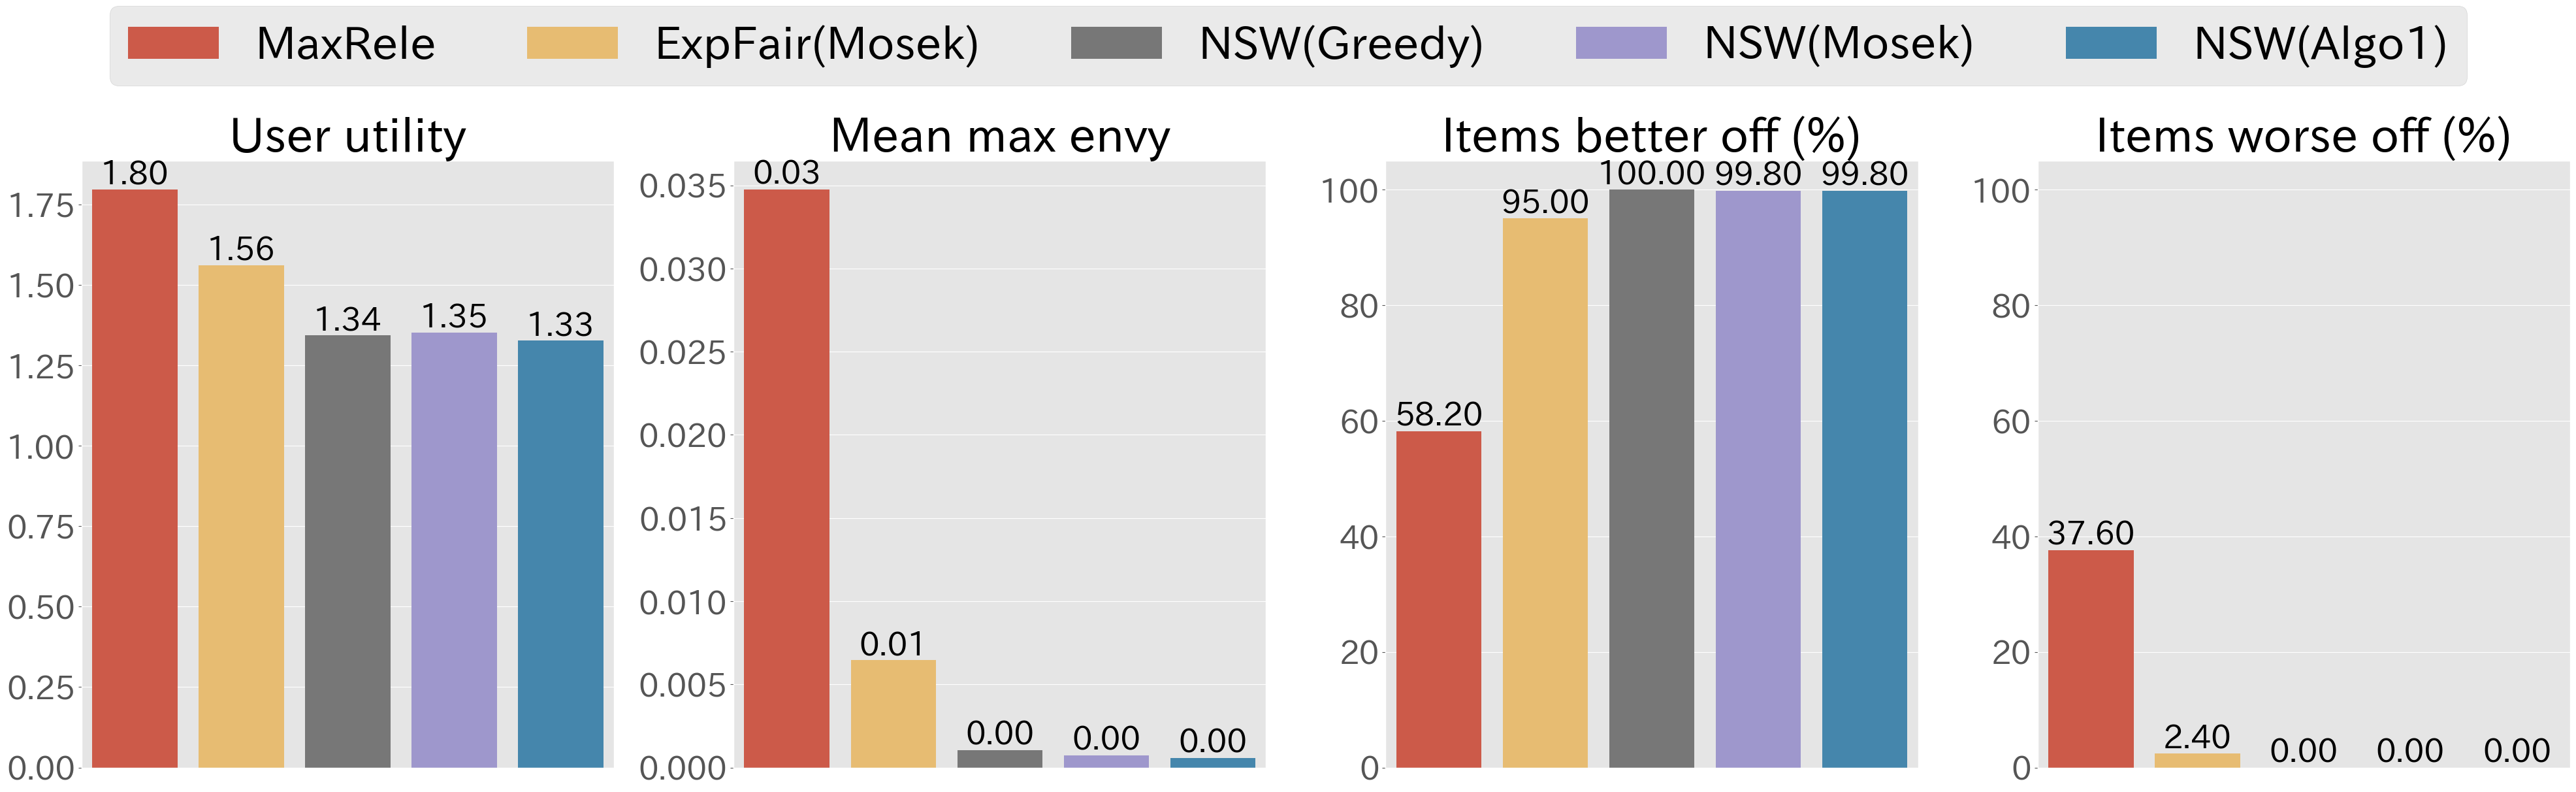

In [19]:
plot_metrics_bar(base_size_real_result)

# アイテム数、利用者数、アイテムのクラスタ数、利用者のクラスタ数を変化させたときの実験

## 公平性、満足度

In [20]:
def plot_fairness_and_user_utils(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    errorbar: Optional[tuple[str, float]] = None,
    metrics: list[str] = [
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
):
    ncols = len(metrics)
    figsize_0 = 45 / 4 * ncols
    fig, axes = plt.subplots(ncols=ncols, figsize=(figsize_0, 10), tight_layout=True)
    axes: list[Axes] = np.ravel(axes).tolist()

    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
                errorbar=errorbar,
            )

            if metric in [
                "pct_item_util_better",
                "pct_item_util_worse",
            ]:
                ax.set_ylim(-5, 105)
            elif metric == "exec_time":
                ax.set_yscale("log")
                ax.set_ylim(bottom=5e-1, top=5e3)

        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel(xlabel, fontsize=42)
        ax.tick_params(axis="both", labelsize=35)

        handles, _ = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    if legend:
        fig.legend(
            handles,
            order,
            fontsize=50,
            bbox_to_anchor=(0.5, 1.15),
            ncol=len(order),
            loc="upper center",
        )

In [21]:
# アイテム数を変化させた場合
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_item"],
    on=["generator_params_n_doc", "seed"],
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
)
display(varying_item_size_result.head(5))

# 利用者数を変化させた場合
varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_params_n_query", "seed"],
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
)
display(varying_user_size_result.head(5))

# クラスタ数を変化させた場合
varying_cluster_size_result = pd.read_csv(RESULT_PATH)
varying_cluster_size_result = varying_cluster_size_result.query(
    "exp_name == 'exp_cluster_2'"
).reset_index(drop=True)
varying_cluster_size_result["n_params"] = (
    100
    * (
        varying_cluster_size_result["optimizer_params_n_doc_cluster"]
        * varying_cluster_size_result["optimizer_params_n_query_cluster"]
    )
    / (
        varying_cluster_size_result["generator_params_n_doc"]
        * varying_cluster_size_result["generator_params_n_query"]
    )
)
varying_cluster_size_result["method"] = "NSW(Algo1+GPU)"
display(varying_cluster_size_result.head(5))

,number_of_nan
exec_time,0
exec_time_rate,15
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,NSW(Algo1),0.902199,0.000814,2.146827,0.000066,97.9375,0.2500,1108.811406,NaN,2.146756,0.000014,97.7500,0.250
1,1600,1,NSW(Algo1),0.903618,0.000750,2.163427,0.000065,97.1875,0.1875,1205.428054,NaN,2.158890,0.000014,97.6250,0.250
2,1600,0,NSW(Algo1),0.904104,0.000788,2.148826,0.000065,97.8750,0.0625,1147.260273,NaN,2.148788,0.000015,97.5625,0.000
3,800,4,NSW(Algo1),0.430397,0.001742,2.158281,0.000056,97.6250,0.3750,247.035245,NaN,2.159054,0.000027,97.5000,0.375
4,800,3,NSW(Algo1),0.470818,0.002049,2.166543,0.000050,97.3750,0.0000,229.724557,NaN,2.167068,0.000029,97.5000,0.125


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600.0,4,NSW(Algo1),0.179429,0.000588,2.152173,0.000198,97.2,0.0,304.957495,NaN,2.158037,0.000071,96.4,0.0
1,1600.0,3,NSW(Algo1),0.182421,0.000606,2.159340,0.000191,97.6,0.0,300.778249,NaN,2.165378,0.000075,96.8,0.0
2,1600.0,2,NSW(Algo1),0.180953,0.000598,2.149911,0.000211,97.2,0.4,302.685821,NaN,2.154444,0.000073,97.2,0.4
3,1600.0,1,NSW(Algo1),0.181002,0.000598,2.161106,0.000157,97.2,0.0,302.672586,NaN,2.167133,0.000070,96.8,0.0
4,1600.0,0,NSW(Algo1),0.184045,0.000625,2.135681,0.000164,97.6,0.0,294.552099,NaN,2.139198,0.000074,97.2,0.0


,seed,exp_name,generator_K,generator_name,generator_shape,generator_params_lam,generator_params_n_doc,generator_params_noise,generator_params_n_query,generator_params_flip_ratio,...,optimizer_params_method,optimizer_params_last_ot_n_iter,optimizer_params_apply_negative_to_X_bf_sa,generator_params_path,generator_params_dataset,generator_params_eps_plus,generator_params_eps_minus,generator_params_test_size,n_params,method
0,3,exp_cluster_2,5,synthetic,inv,1,5000,0.05,10000.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
1,2,exp_cluster_2,5,synthetic,inv,1,5000,0.05,10000.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
2,1,exp_cluster_2,5,synthetic,inv,1,5000,0.05,10000.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
3,0,exp_cluster_2,5,synthetic,inv,1,5000,0.05,10000.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
4,4,exp_cluster_2,5,synthetic,inv,1,5000,0.05,10000.0,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,NSW(Algo1+GPU)


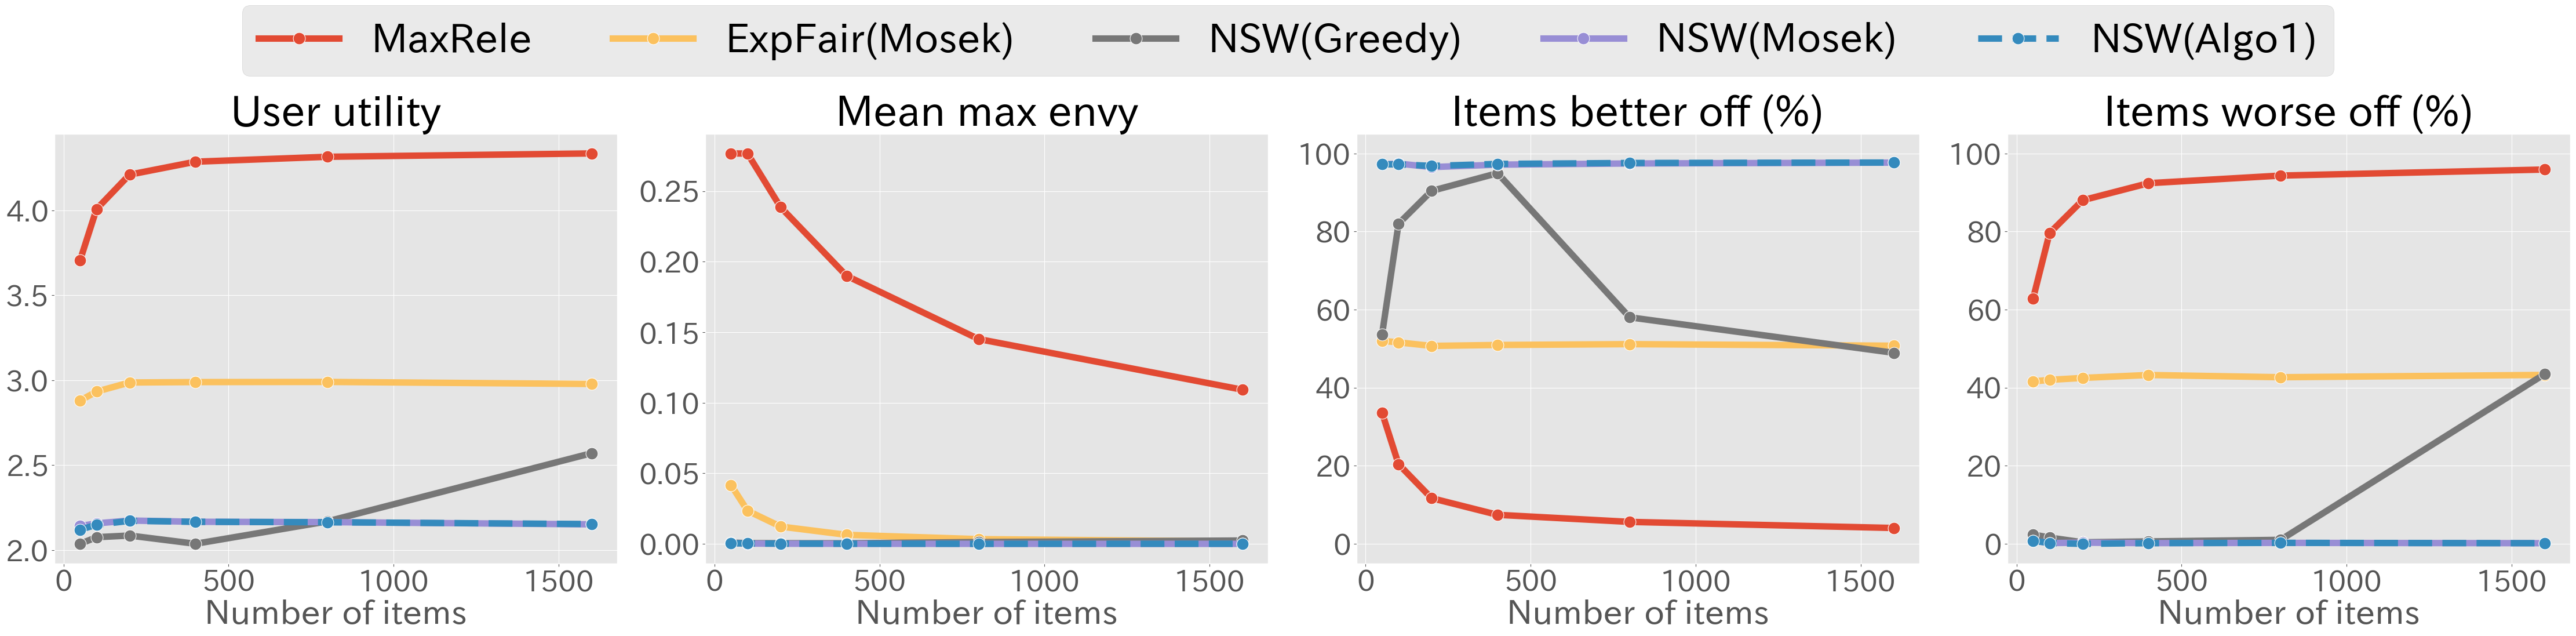

In [22]:
plot_fairness_and_user_utils(
    varying_item_size_result, x="generator_params_n_doc", xlabel="Number of items"
)

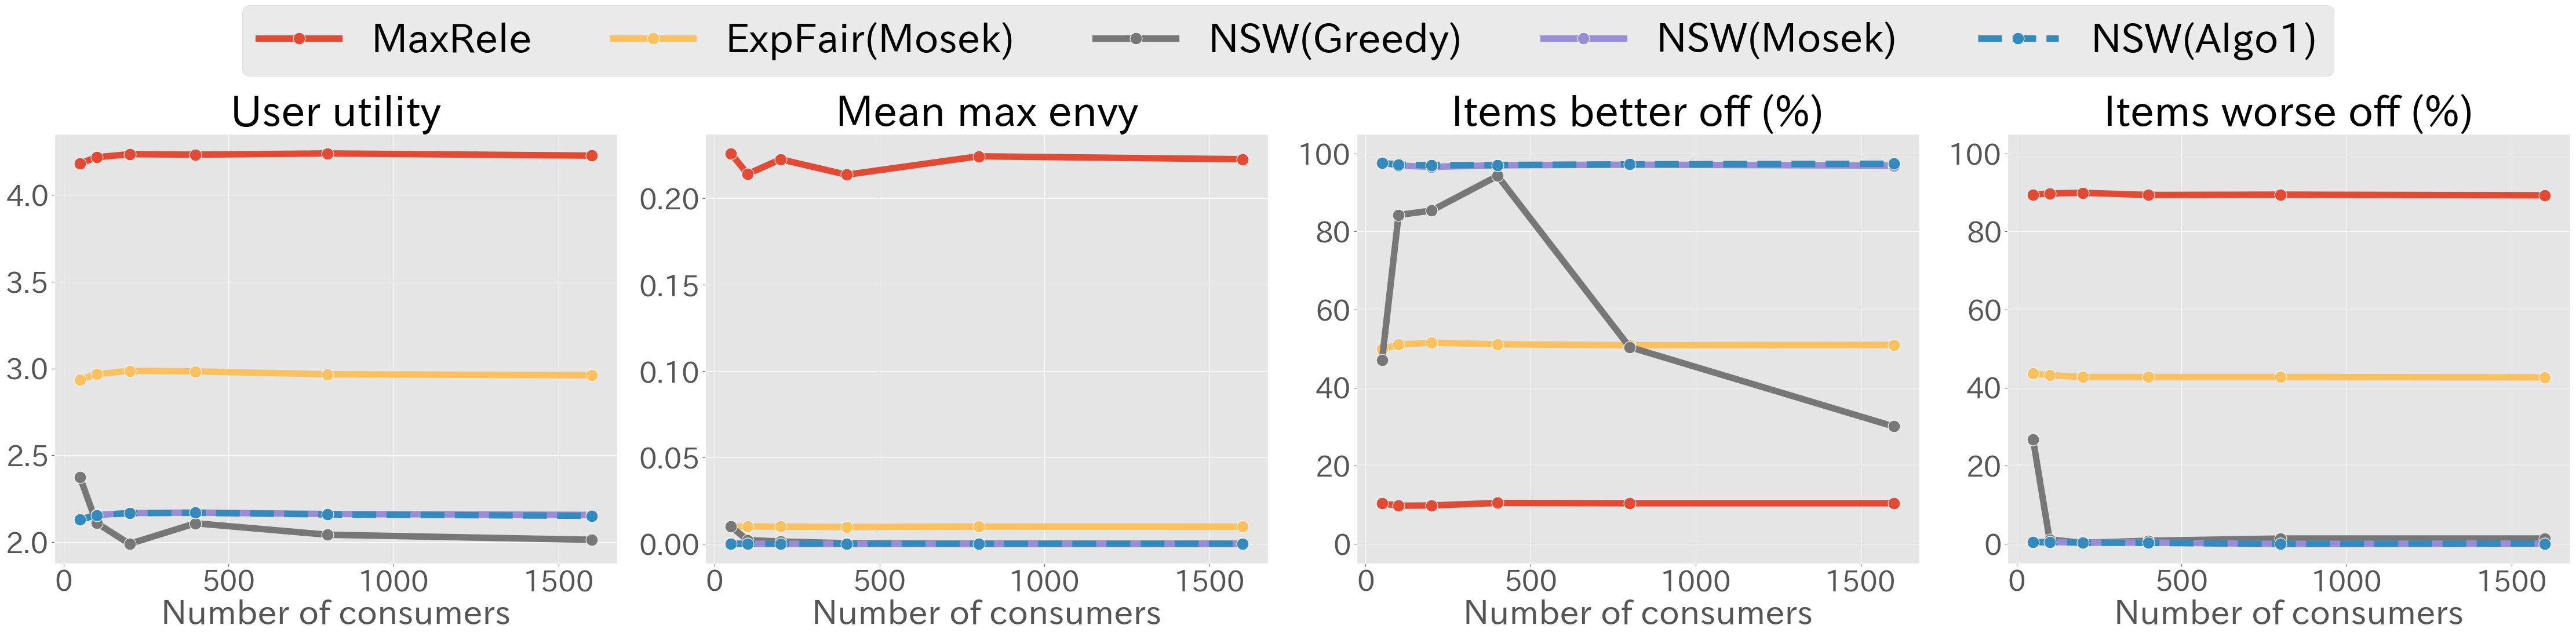

In [23]:
plot_fairness_and_user_utils(
    varying_user_size_result, x="generator_params_n_query", xlabel="Number of consumers"
)

## クラスタ数を変化させたときの実験

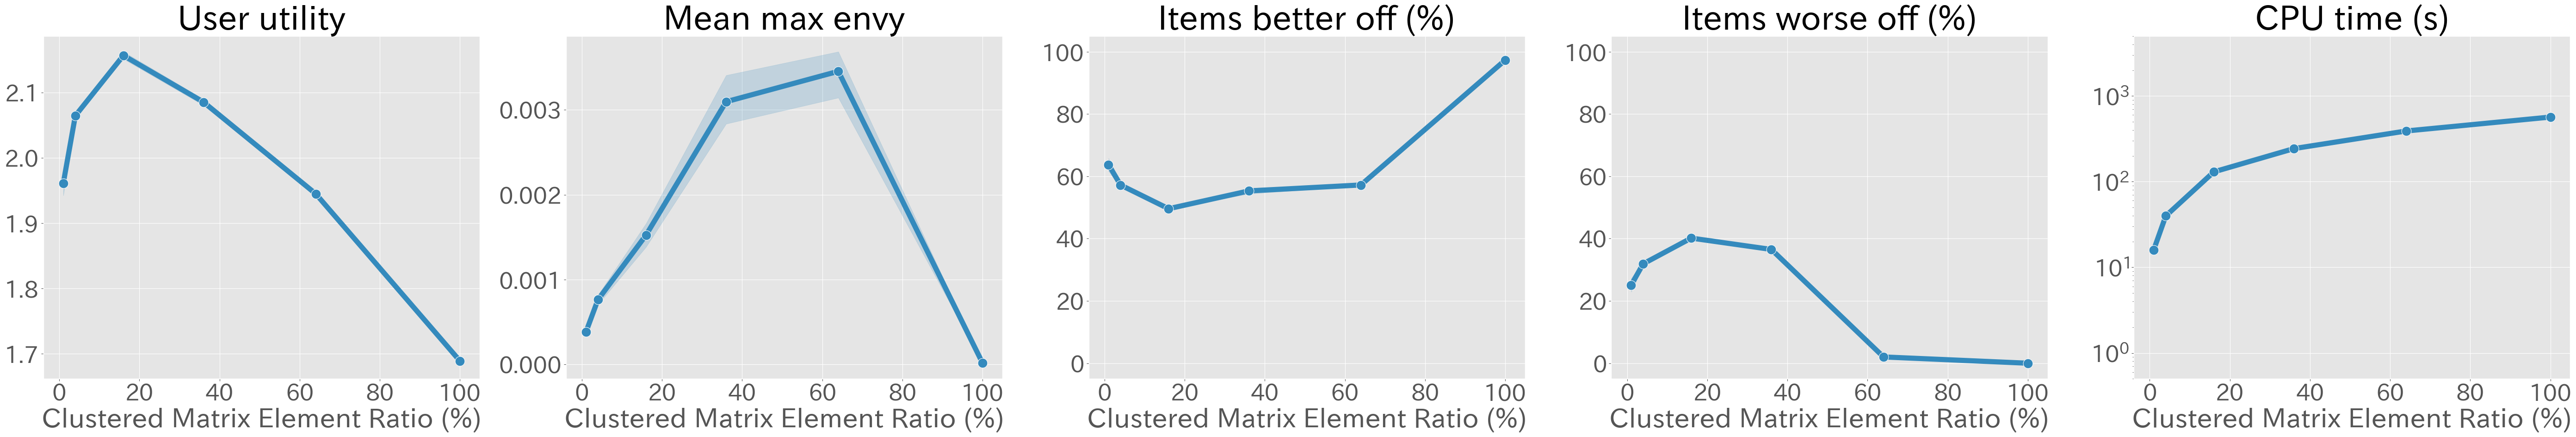

In [24]:
plot_fairness_and_user_utils(
    varying_cluster_size_result,
    x="n_params",
    xlabel="Clustered Matrix Element Ratio (%)",
    legend=False,
    errorbar=("ci", 95),
    metrics=[
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
        "exec_time",
    ],
)

### クラスタ数とデータ数を変化させたときの実験

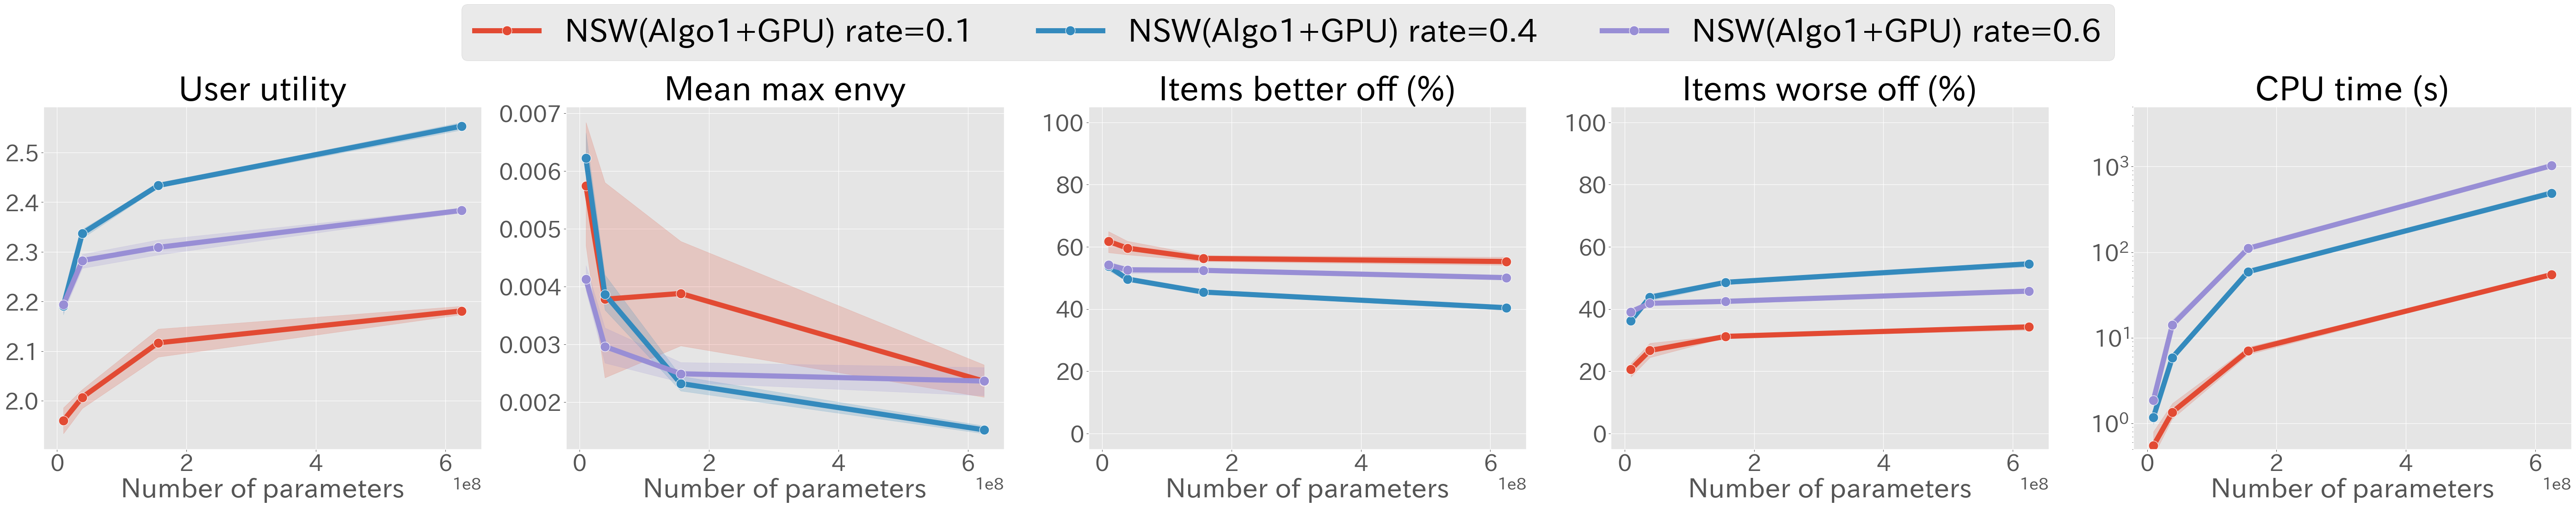

In [68]:
varying_cluster_data_size_result = pd.read_csv(RESULT_PATH)
varying_cluster_data_size_result = varying_cluster_data_size_result.query(
    "exp_name == 'exp_cluster_datasize'"
).reset_index(drop=True)
varying_cluster_data_size_result["datasize"] = (
    varying_cluster_data_size_result["generator_params_n_doc"]
    * varying_cluster_data_size_result["generator_params_n_query"]
    * varying_cluster_data_size_result["generator_K"]
)
varying_cluster_data_size_result["cluster_rate"] = (
    varying_cluster_data_size_result["optimizer_params_n_query_cluster"]
    / varying_cluster_data_size_result["generator_params_n_query"]
).round(1)
varying_cluster_data_size_result["method"] = varying_cluster_data_size_result[
    "cluster_rate"
].apply(lambda x: f"NSW(Algo1+GPU) rate={x}")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
methods = varying_cluster_data_size_result["method"].unique()
methods = sorted(methods, key=lambda x: float(x.split("=")[1]))

for i, method in enumerate(methods):
    METHOD_TO_COLOR[method] = colors[i]
    METHOD_TO_LINESTYLE[method] = "-"

plot_fairness_and_user_utils(
    varying_cluster_data_size_result,
    x="datasize",
    xlabel="Number of parameters",
    legend=True,
    errorbar=("ci", 95),
    metrics=[
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
        "exec_time",
    ],
)

## 実行時間

In [14]:
def plot_exec_time(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    figsize: tuple[int, int] = (14, 10),
    ax: Optional[plt.Axes] = None,
):
    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for j, method in enumerate(order):
        color = METHOD_TO_COLOR[method]
        sns.lineplot(
            result.query("method == @method"),
            x=x,
            y="exec_time",
            ax=ax,
            marker="o",
            markersize=15,
            markers=True,
            linewidth=8,
            linestyle=METHOD_TO_LINESTYLE[method],
            legend=True,
            color=color,
            hue="method",
            palette=[color],
            errorbar=None,
        )
    ax.set_ylabel(METRICS_MAP["exec_time"], fontsize=40)
    ax.set_xlabel(xlabel, fontsize=40)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-3, top=3e3)
    ax.tick_params(axis="both", labelsize=30)

    if legend:
        handles, legend = ax.get_legend_handles_labels()
        ax.legend(
            handles,
            legend,
            loc="upper center",
            ncol=3,
            bbox_to_anchor=(0.5, 1.20),
        )
    else:
        ax.get_legend().remove()

    if ax is None:
        fig.tight_layout()

    return ax


def plot_only_legend(ncol: int = 4, methods: list[str] = METHOD_TO_COLOR.keys()):
    fig, ax = plt.subplots(figsize=(14, 10))
    for method in methods:
        ax.plot([], [], label=method, color=METHOD_TO_COLOR[method], linewidth=8)
    ax.legend(
        loc="upper center",
        ncol=ncol,
        bbox_to_anchor=(0.5, 1.20),
        fontsize=40,
    )
    ax.axis("off")

In [15]:
ideal_method = "NSW(Mosek)"
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_item"],
    on=["generator_params_n_doc", "seed"],
    ideal_method=ideal_method,
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
    consider_device=True,
)
display(varying_item_size_result.head(5))

varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_params_n_query", "seed"],
    ideal_method=ideal_method,
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
    consider_device=True,
)
display(varying_user_size_result.head(5))

,number_of_nan
exec_time,0
exec_time_rate,18
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,NSW(Algo1),13.274020,0.011971,2.146716,0.000062,98.0000,0.2500,1108.811406,NaN,2.146756,0.000014,97.7500,0.250
1,1600,1,NSW(Algo1),12.886611,0.010690,2.163428,0.000051,97.1875,0.1875,1205.428054,NaN,2.158890,0.000014,97.6250,0.250
2,1600,0,NSW(Algo1),12.819183,0.011174,2.148774,0.000047,97.8750,0.0625,1147.260273,NaN,2.148788,0.000015,97.5625,0.000
3,800,4,NSW(Algo1),3.349156,0.013557,2.158250,0.000049,97.6250,0.3750,247.035245,NaN,2.159054,0.000027,97.5000,0.375
4,800,3,NSW(Algo1),3.235251,0.014083,2.166454,0.000045,97.3750,0.0000,229.724557,NaN,2.167068,0.000029,97.5000,0.125


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600.0,4,NSW(Algo1),2.619791,0.008591,2.152172,0.000198,97.2,0.0,304.957495,NaN,2.158037,0.000071,96.4,0.0
1,1600.0,3,NSW(Algo1),2.751615,0.009148,2.159342,0.000191,97.6,0.0,300.778249,NaN,2.165378,0.000075,96.8,0.0
2,1600.0,2,NSW(Algo1),2.682551,0.008862,2.149910,0.000212,97.2,0.4,302.685821,NaN,2.154444,0.000073,97.2,0.4
3,1600.0,1,NSW(Algo1),2.527505,0.008351,2.161106,0.000157,97.2,0.0,302.672586,NaN,2.167133,0.000070,96.8,0.0
4,1600.0,0,NSW(Algo1),2.683425,0.009110,2.135680,0.000164,97.6,0.0,294.552099,NaN,2.139198,0.000074,97.2,0.0


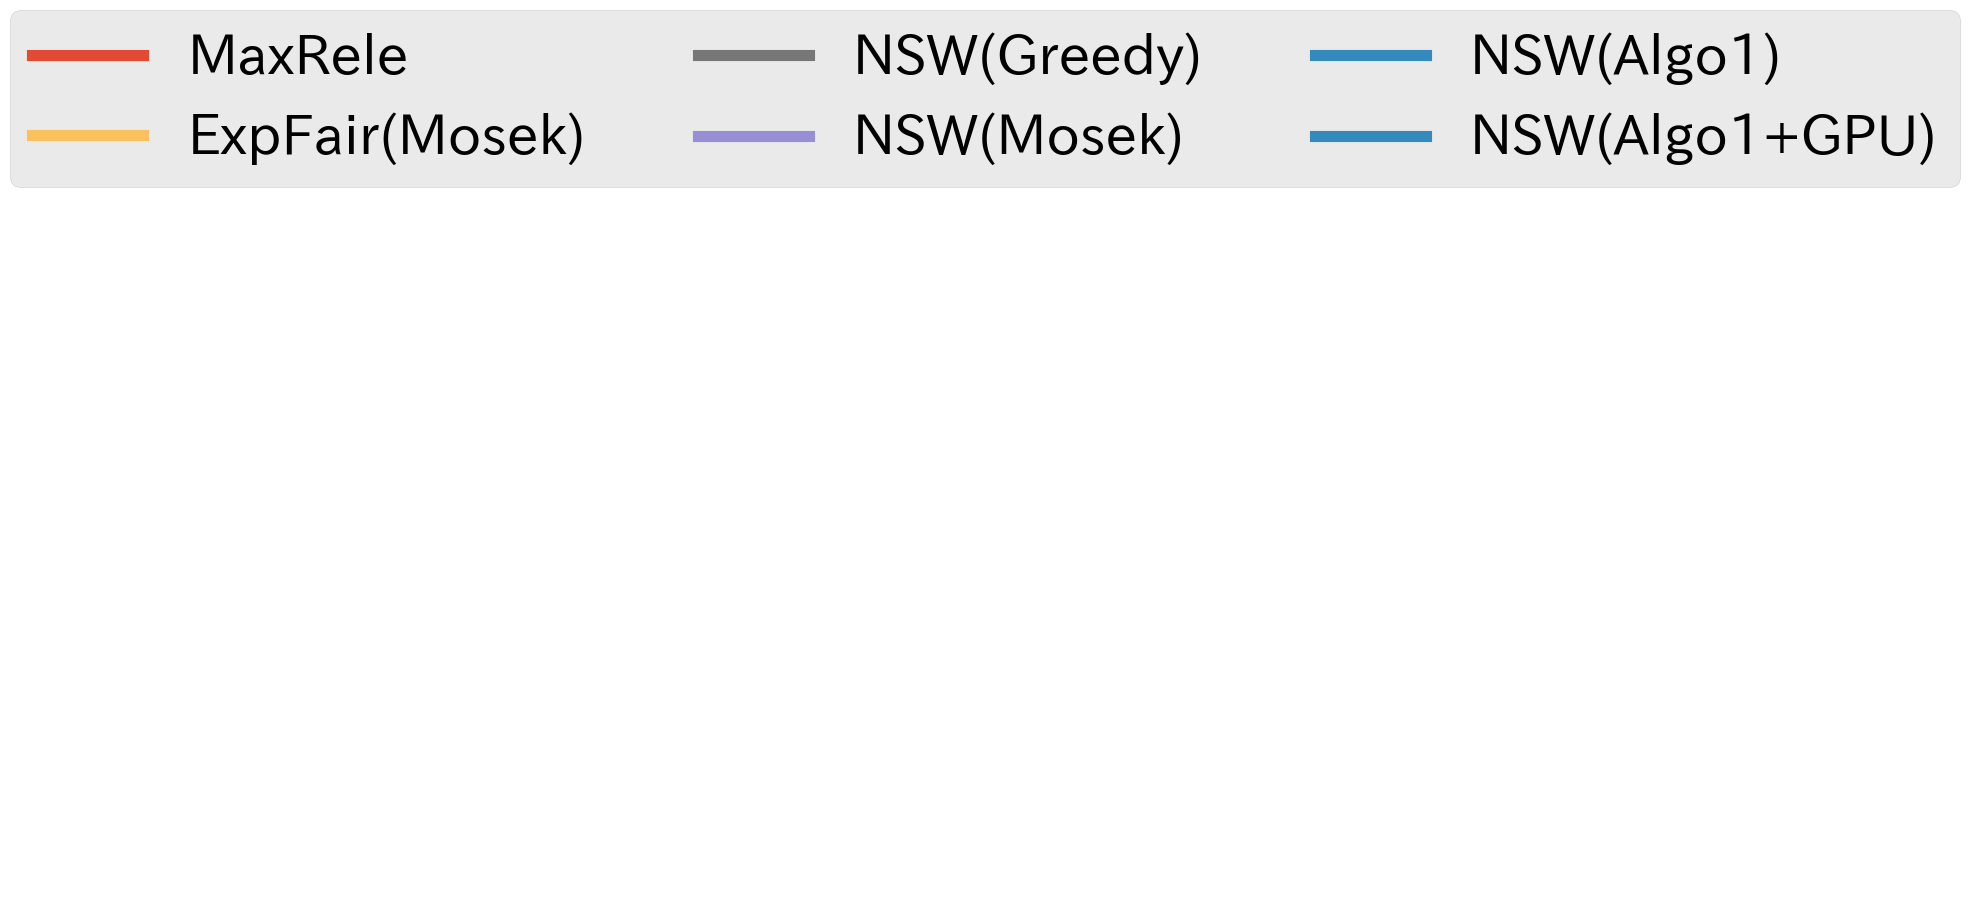

In [16]:
plot_only_legend(
    ncol=3,
    methods=[
        "MaxRele",
        "ExpFair(Mosek)",
        "NSW(Greedy)",
        "NSW(Mosek)",
        "NSW(Algo1)",
        "NSW(Algo1+GPU)",
    ],
)

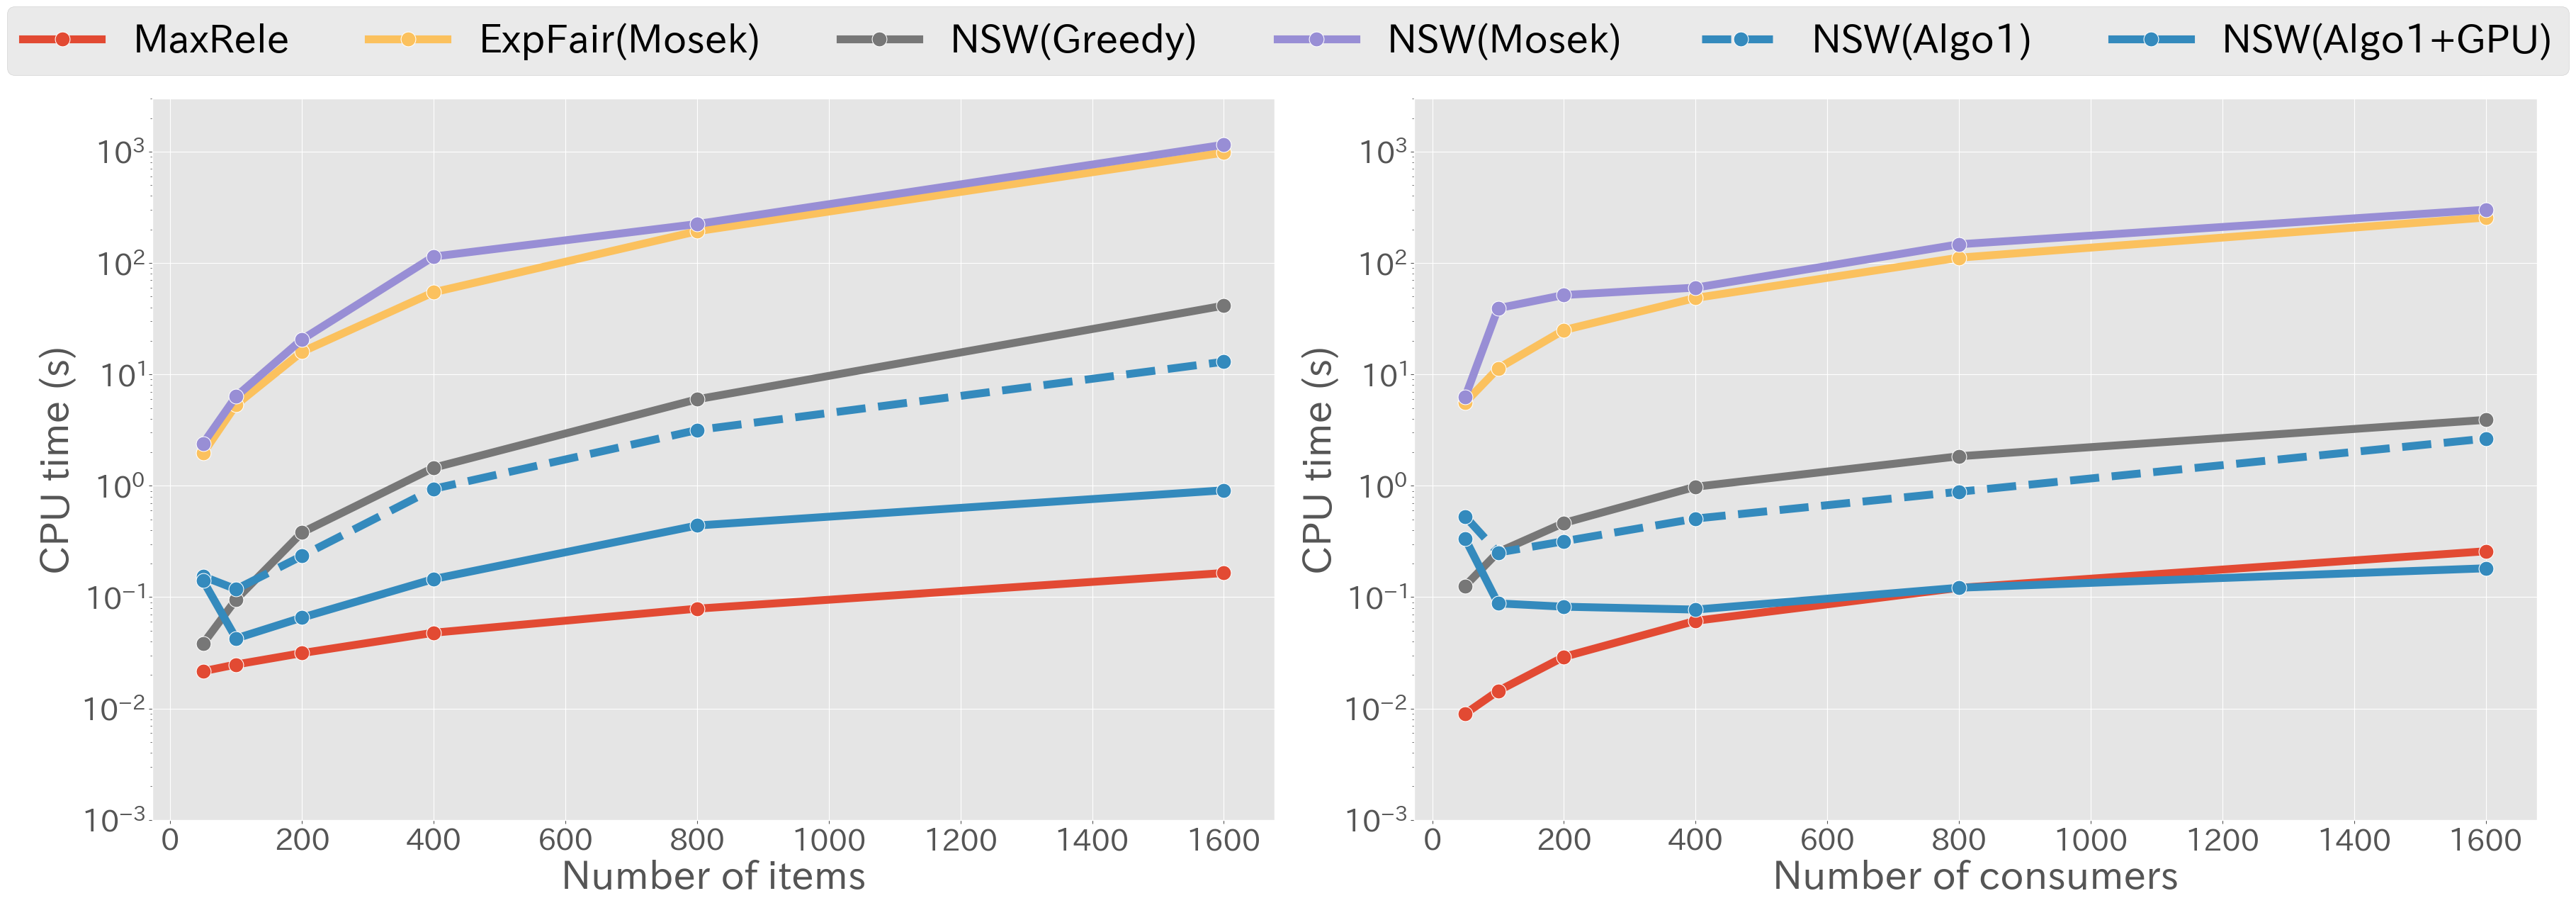

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18 * 2, 12))


plot_exec_time(
    varying_item_size_result,
    x="generator_params_n_doc",
    xlabel="Number of items",
    legend=True,
    ax=axes[0],
)

plot_exec_time(
    varying_user_size_result,
    x="generator_params_n_query",
    xlabel="Number of consumers",
    ax=axes[1],
    legend=False,
)

# legend
handles, legend = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
fig.legend(
    handles,
    legend,
    fontsize=40,
    bbox_to_anchor=(0.5, 1.10),
    ncol=6,
    loc="upper center",
)

fig.tight_layout()

<Axes: xlabel='Clustered Matrix Element Ratio (%)', ylabel='CPU time (s)'>

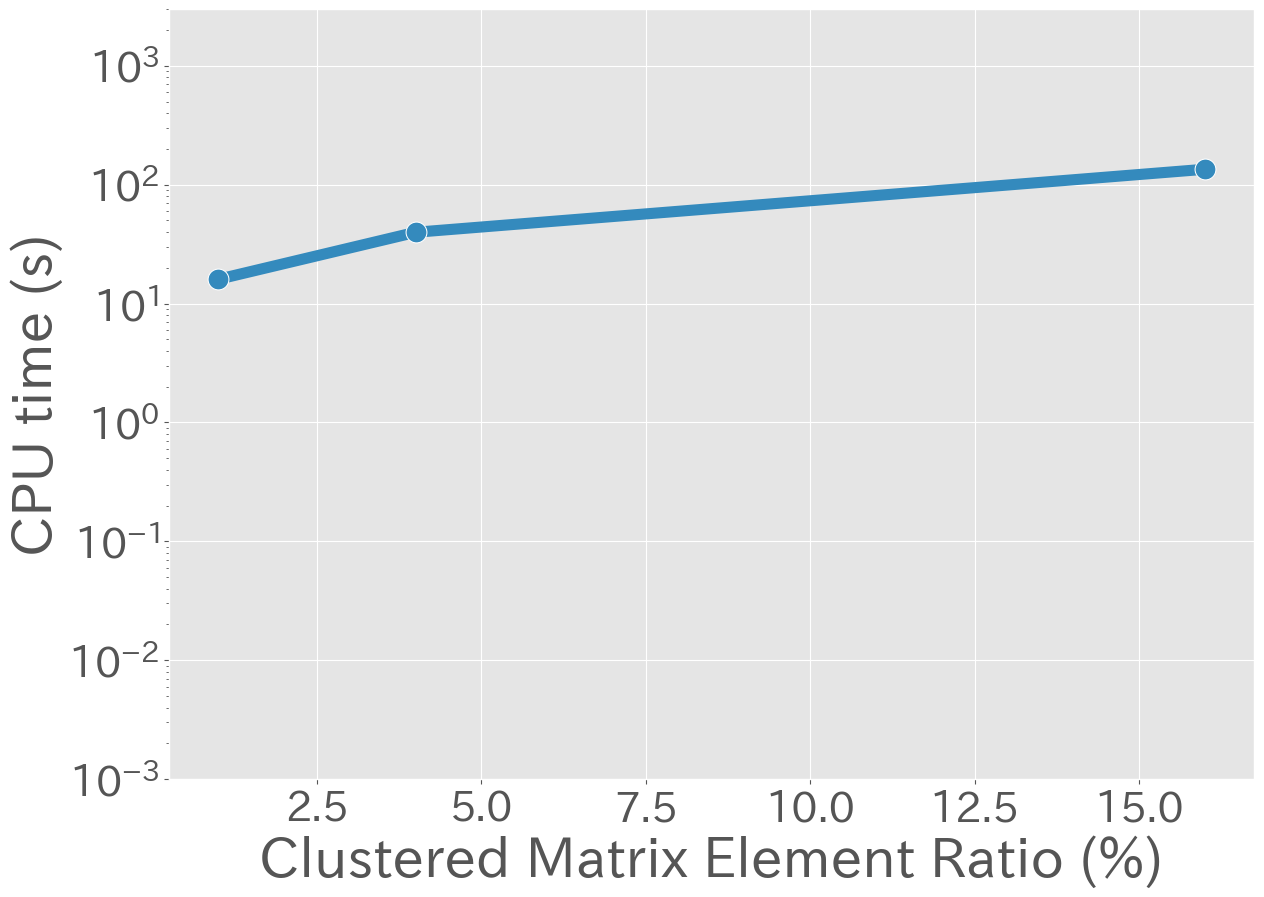

In [18]:
plot_exec_time(
    varying_cluster_size_result,
    x="n_params",
    xlabel="Clustered Matrix Element Ratio (%)",
    legend=False,
)